In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from hcnn import HCNN
from loss_functions import LogCosh

# Synthetic data

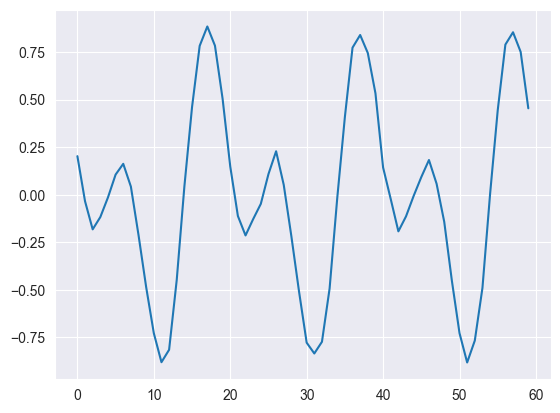

In [26]:
def sample_data(sample_size, signal_freq=60):
    import random
    def sine(X, signal_freq=60.):
        return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

    def noisy(Y, noise_range=(-0.05, 0.05)):
        noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
        return Y + noise

    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine(X + random_offset, signal_freq))
    return Y

data = sample_data(60, 20).reshape(-1, 1)
plt.plot(data)

In [27]:
hcnn = HCNN(data_dim=data.shape[1], hidden_dim=20, init_state_trainable=True)

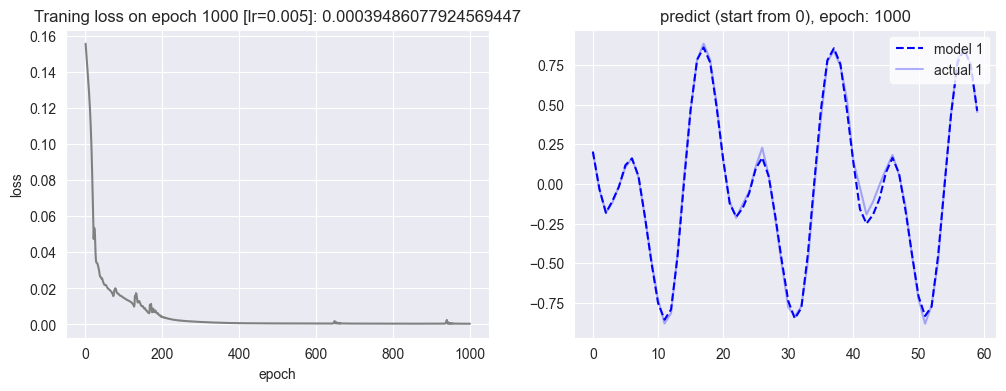

In [28]:
train_loss = hcnn.train(
    data, 
    lr=0.005, epochs=1000, 
    criterion=LogCosh.apply, # criterion=torch.nn.MSELoss() or criterion=LogCosh.apply
    plot_loss=False, plot_pred_train=True, verbose=False
)  

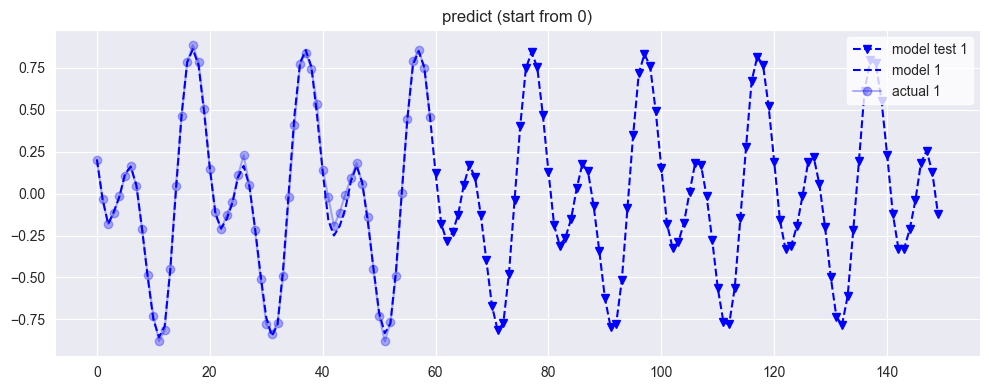

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

pred = hcnn.sample(hcnn.hcnn.init_state, int(len(data))+1)
pred_test = hcnn.sample(hcnn.forward(hcnn.hcnn.init_state, len(data)), int(len(data)*1.5))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model test {c+1}', color=colors[c], alpha=1)
    ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data[:, c], 'o-', label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

# Airline passengers data

<Axes: >

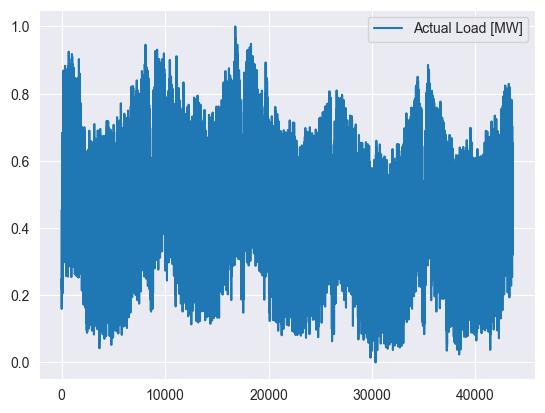

In [193]:
df = pd.read_csv(r"F:\Semml\comparative-analysis-energy-timeseries-forecasting-semml\Enriched_data.csv", index_col=0)
# df.index = range(0, len(df))
# df /= 1000
# df = df[["Actual Load [MW]","temperature"]]
df = df["Actual Load [MW]"]
df = (df - df.min())/(df.max() - df.min())
df.index = range(0, len(df))
# df["temperature"] = (df["temperature"] - df["temperature"].min())/(df["temperature"].max() - df["temperature"].min())
# Convert to DataFrame
df = pd.DataFrame(df)
df.plot()

In [380]:
training_horizon = 240
forecast_horizon = 24
df = pd.read_csv(r"F:\Semml\comparative-analysis-energy-timeseries-forecasting-semml\Enriched_data.csv", index_col=0)
df = df["Actual Load [MW]"]
df = df[df.shape[0] - training_horizon - forecast_horizon :]
df.index = range(0, len(df))
max, min = df.max(), df.min()
df = (df - min)/(max - min)
data_train = df[df.shape[0] - training_horizon - forecast_horizon : df.shape[0] - forecast_horizon]
test = df[df.shape[0] - forecast_horizon :]

df = pd.DataFrame(df)
data_train = pd.DataFrame(data_train)
test = pd.DataFrame(test)

In [381]:
max, min

(71999.25, 42895.0)

In [382]:
data_train.shape

(240, 1)

In [383]:
hcnn = HCNN(data_dim=data_train.shape[1], hidden_dim=200, sparsity=0, init_state_trainable=False)
init_state = hcnn.init_state()

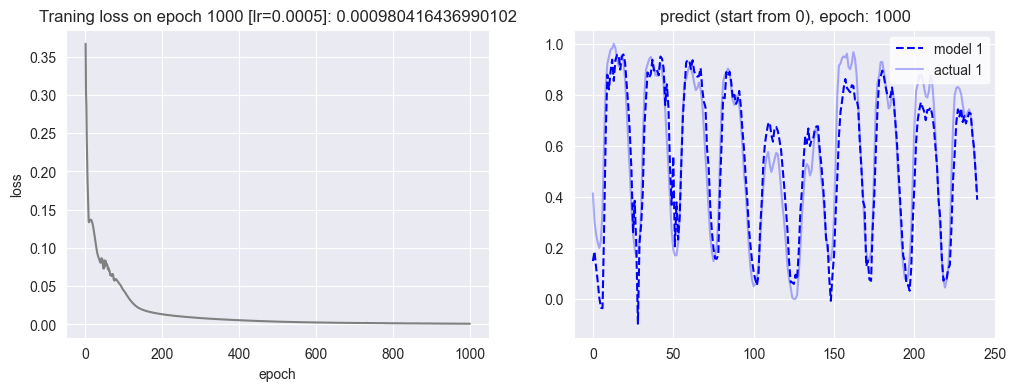

In [384]:
import torch

train_loss = hcnn.train(
    data_train.values, 
    init_state, 
    lr=0.0005, epochs=1000, 
    criterion=torch.nn.MSELoss(), #LogCosh.apply, 
    plot_pred_train=True
)

In [385]:
y_pred_test = hcnn.sample(hcnn.forward(init_state, len(data_train)), len(test))
y_pred = hcnn.sample(init_state, len(data_train))

In [386]:
y_pred_test.shape

(24, 1)

In [387]:
y_pred_test

array([[ 0.26234853],
       [ 0.22618067],
       [ 0.07699791],
       [-0.01098523],
       [ 0.07532203],
       [ 0.11406188],
       [ 0.23403269],
       [ 0.32243323],
       [ 0.5094491 ],
       [ 0.63372356],
       [ 0.7009161 ],
       [ 0.75447863],
       [ 0.7804867 ],
       [ 0.73906314],
       [ 0.7421995 ],
       [ 0.71216923],
       [ 0.7461054 ],
       [ 0.7289676 ],
       [ 0.69730335],
       [ 0.7243178 ],
       [ 0.68657815],
       [ 0.561821  ],
       [ 0.49500838],
       [ 0.37855947]], dtype=float32)

In [388]:
df.iloc[[0]].values + 40

array([[40.41461299]])

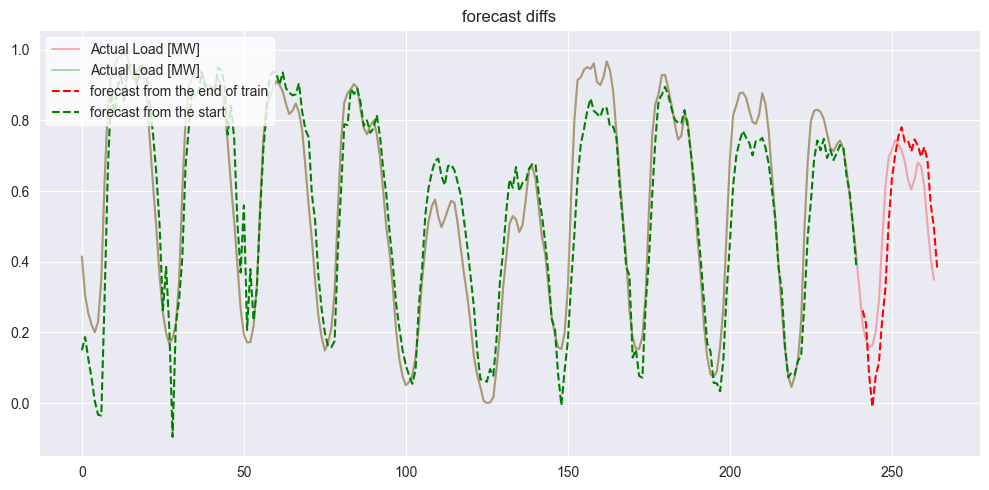

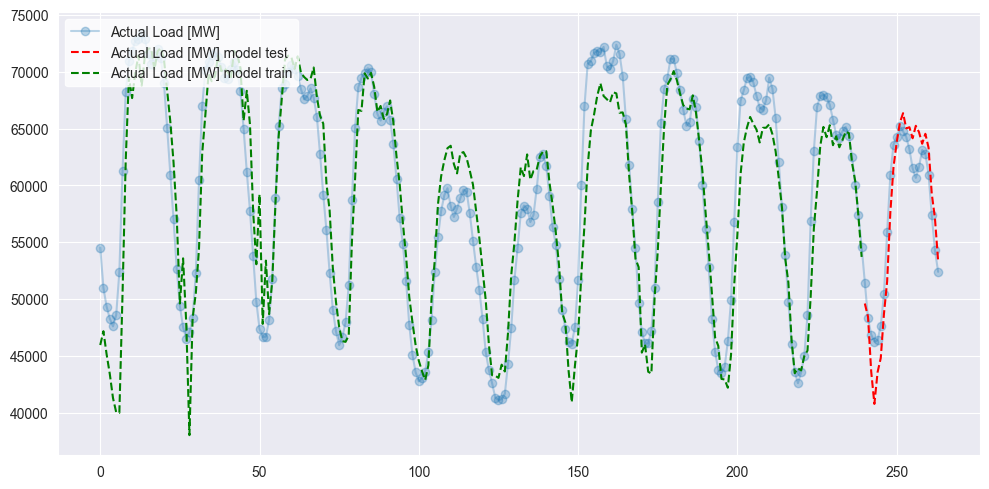

In [389]:
# PLOT forecast of diffs
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, title='forecast diffs', color='r', alpha=0.3)
data_train.plot(ax=ax, color='g', alpha=0.3)
ax.plot(np.arange(1, y_pred_test.shape[0]+1) + len(data_train), y_pred_test, 'r--', label=f'forecast from the end of train')
ax.plot(data_train.index, y_pred, 'g--', label=f'forecast from the start')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()
plt.show()

# PLOT FORECAST after diff inverse transform
# def diff_inverse_transform(df, first_row):
#     df_ = first_row
#     for i in range(df.shape[0]):
#         row = pd.DataFrame(data=df.iloc[[i]].values + df_.iloc[[i]].values, 
#                            columns=df.columns, index=df.iloc[[i]].index)
#         # df_ = df_.append(row)
#         # Assuming `row` is a dictionary or a DataFrame
#         df_ = pd.concat([df_, pd.DataFrame([row])], ignore_index=True)
#     return df_.iloc[1:]


def diff_inverse_transform(df, first_row, max = 73442.25, min =  41132.5):
    df_ = first_row.copy()  # Copy to avoid modifying the original
    for i in range(len(df)):
        # Compute the row and ensure it's 2D
        row_values = (max - min)*(df.iloc[[i]].values) + min  # Use last row of df_ for addition
        row = pd.DataFrame(
            data=row_values,  # Ensure data is 2D
            columns=df.columns,
            index=df.iloc[[i]].index,
        )
        
        # Concatenate instead of appending
        df_ = pd.concat([df_, row])
    return df_.iloc[1:]  # Drop the first row if it was only for initialization


y_pred_test = pd.DataFrame(data=y_pred_test, columns=df.columns)#.rename('forecast from the end of train'])
y_pred_test.index = df.loc[data_train.index[-1]+1:].index
df_forecast_test = diff_inverse_transform(y_pred_test, df.loc[[data_train.index[-1]]])
df_forecast_test.rename(columns={c: '{} model test'.format(c) for c in df_forecast_test.columns}, inplace=True)

y_pred = pd.DataFrame(data=y_pred, columns=df.columns, index=data_train.index) # columns=['forecast from the start']
df_forecast = diff_inverse_transform(y_pred, df.loc[[0]])
df_forecast.rename(columns={c: '{} model train'.format(c) for c in df_forecast.columns}, inplace=True)

df = diff_inverse_transform(df, df.loc[[0]])

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, style='o-', alpha=0.3)
df_forecast_test.plot(ax=ax, style='r--')
df_forecast.plot(ax=ax, style='g--')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

In [390]:
df_forecast_test

,Actual Load [MW] model test
240,49608.914062
241,48440.339844
242,43620.281250
243,40777.570312
244,43566.136719
245,44817.812500
246,48694.039062
247,51550.238281
248,57592.671875
249,61607.949219


In [391]:
from pydantic import BaseModel, Field
class ModelConfig(BaseModel):
    forecast_horizon: int = Field(..., description="Forecasting horizon in hours")
    training_horizon: int = Field(..., description="Training horizon in hours")
    n_splits: int = Field(..., description="Number of train-test splits")
    model_name: str = Field(..., description="Name of the model")
    output_dir: str = Field(..., description="Directory to save CSV outputs")

In [409]:
dataset = pd.read_csv(r"F:\Semml\comparative-analysis-energy-timeseries-forecasting-semml\Enriched_data.csv")
    
# Define Configuration
config = ModelConfig(
    forecast_horizon=24,
    training_horizon=240,
    n_splits=5,
    model_name="HCNN", 
    output_dir="outputs"
)

In [412]:
def preprocess_data(dataset: pd.DataFrame, config: ModelConfig, iteration : int):

    df = dataset[["timestamp", "Actual Load [MW]"]].copy()
    # df.set_index("timestamp", inplace = True)

    start_index = df.shape[0] - config.training_horizon - config.forecast_horizon - iteration * config.forecast_horizon
    end_index = start_index + config.training_horizon + config.forecast_horizon
    start_datetime = df["timestamp"].iloc[start_index - 1] 
    end_datetime = df["timestamp"].iloc[end_index - 1]
    df.drop("timestamp", axis = 1,  inplace = True)

    df.index = range(0, len(df))
    df = df[start_index : end_index]
    max, min = df.max(), df.min()
    df = (df - min)/(max - min)

    data_train = df[: config.training_horizon]
    test = df[config.training_horizon :]

    df = pd.DataFrame(df)
    data_train = pd.DataFrame(data_train)
    test = pd.DataFrame(test)
    
    return df, data_train, test, max, min, start_datetime, end_datetime

In [413]:
df, data_train, test, max, min, start_datetime, end_datetime = preprocess_data(dataset, config,  iteration = 0)

(Actual Load [MW]    71999.25
 dtype: float64,
 Actual Load [MW]    42895.0
 dtype: float64,
 '2024-12-09 22:00:00',
 '2024-12-20 22:00:00')

In [414]:
start_datetime, end_datetime

('2024-12-09 22:00:00', '2024-12-20 22:00:00')

In [427]:
from datetime import datetime, timedelta
def train_and_forecast(dataset: pd.DataFrame, config: ModelConfig):
    """
    Train a model and forecast based on the provided dataset and configuration.
    """
    # df = dataset["Actual Load [MW]"].copy()

    combined_forecast = pd.DataFrame()

    for i in reversed(range(config.n_splits)):

        df, data_train, test, max, min, start_datetime, end_datetime = preprocess_data(dataset, config, iteration = i)

        hcnn = HCNN(data_dim=data_train.shape[1], hidden_dim=200, sparsity=0, init_state_trainable=False)
        init_state = hcnn.init_state()

        train_loss = hcnn.train(
            data_train.values, 
            init_state, 
            lr=0.0005, epochs=1000, 
            criterion=torch.nn.MSELoss(), #LogCosh.apply, 
            plot_pred_train=False
        )

        y_pred_test = hcnn.sample(hcnn.forward(init_state, len(data_train)), len(test))
        y_pred = hcnn.sample(init_state, len(data_train))

        y_pred_test = pd.DataFrame(data=y_pred_test, columns=df.columns)#.rename('forecast from the end of train'])
        y_pred_test.index = df.loc[data_train.index[-1]+1:].index
        df_forecast_test = diff_inverse_transform(y_pred_test, df.loc[[data_train.index[-1]]])
        df_forecast_test.rename(columns={c: '{} model test'.format(c) for c in df_forecast_test.columns}, inplace=True)
        
        # Generate the timestamp column with 1-hour resolution
        # Convert the string to a datetime object
        end_datetime = datetime.strptime(end_datetime, "%Y-%m-%d %H:%M:%S")
        timestamps = pd.date_range(start=end_datetime, end=end_datetime + timedelta(hours=23) , freq='H')
        df_forecast_test["timestamp"] = timestamps

        combined_forecast = pd.concat([combined_forecast, df_forecast_test], ignore_index=True)

    # Save the forecasts
    return combined_forecast

In [428]:
combined_forecast = train_and_forecast(dataset, config)

C:\Users\HP\AppData\Local\Temp\ipykernel_14532\3628162875.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=end_datetime, end=end_datetime + timedelta(hours=23) , freq='H')
C:\Users\HP\AppData\Local\Temp\ipykernel_14532\3628162875.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=end_datetime, end=end_datetime + timedelta(hours=23) , freq='H')
C:\Users\HP\AppData\Local\Temp\ipykernel_14532\3628162875.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=end_datetime, end=end_datetime + timedelta(hours=23) , freq='H')
C:\Users\HP\AppData\Local\Temp\ipykernel_14532\3628162875.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=end_datetime,

In [429]:
combined_forecast

,Actual Load [MW] model test,timestamp
0,56027.843750,2024-12-16 22:00:00
1,52855.394531,2024-12-16 23:00:00
2,50608.285156,2024-12-17 00:00:00
3,48552.441406,2024-12-17 01:00:00
4,44297.453125,2024-12-17 02:00:00
...,...,...
115,65566.210938,2024-12-21 17:00:00
116,65933.593750,2024-12-21 18:00:00
117,61431.949219,2024-12-21 19:00:00
118,59930.953125,2024-12-21 20:00:00


In [430]:
import os
def save_forecast(forecasts: pd.DataFrame, config: ModelConfig):
    """
    Save the forecast results to a CSV file.
    """
    os.makedirs(config.output_dir, exist_ok=True)
    output_path = os.path.join(config.output_dir, f"{config.model_name}_forecasts.csv")
    forecasts.to_csv(output_path, index=False)
    print(f"Forecasts saved to {output_path}")

In [431]:
save_forecast(combined_forecast, config)

Forecasts saved to outputs\HCNN_forecasts.csv
